In [1]:
import pandas as pd
import numpy as np
from anndata import AnnData
import scanpy as sc
import scipy.sparse as sp
import glob
from tqdm import tqdm
from paste import pairwise_align
import ot
import torch
import matplotlib.pyplot as plt

In [2]:
h5ad_dic = '/home/hanyuji/Data/ST_data/macaque_cortex/h5ad/'
files = 'total_gene_T25.type20230503-macaque1-contour2.h5ad'
data_index = [25,27,28,29,30,31] # 需要加载的切片编号

adatas = []
for index in tqdm(data_index):
    data_path = h5ad_dic + f'total_gene_T{index}.type20230503-macaque1-contour2.h5ad'
    adata = sc.read_h5ad(data_path)
    adatas.append(adata)

100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


In [3]:
# 处理前两个切片作为示例
slice_0 = adatas[3]
slice_1 = adatas[4]


In [4]:
def process_spatial_data(adata):
    '''
    处理obsm['spatial']为指定格式
    '''
    
    adata.obsm['spatial_raw'] = adata.obsm['spatial'].copy()  # 复制obsm['spatial']中的数据
    adata.obsm['spatial'] = np.delete(adata.obsm['spatial'], [0, 1], axis=1)  # 删除obsm['spatial']中的前两列


process_spatial_data(slice_0)
process_spatial_data(slice_1)


In [10]:
def random_subset(adata,cell_num=5000):
    '''
    随机选取 3000 个细胞
    '''
    
    random_indices = np.random.choice(adata.n_obs, cell_num, replace=False)   # 从 276593 个细胞中随机选取 3000 个细胞的索引
    adata_subset = adata[random_indices, :]   # 使用选取的索引创建新的 AnnData 对象

    return adata_subset

slice_0_subset = random_subset(slice_0)
slice_1_subset = random_subset(slice_1)


In [11]:
def get_slice_HVG(slice, n_top_genes=2000, need_norm_and_log1p=False, target_sum=1e4):
    '''
    计算并选择前2000个高可变基因
    '''
    
    slice.var_names_make_unique()  # 确保变量名唯一，避免重复
    sc.pp.filter_genes(slice, min_counts=5)  # 过滤掉计数小于5的基因
    sc.pp.highly_variable_genes(slice, n_top_genes=n_top_genes, flavor='seurat_v3')  # 使用seurat_v3方法计算高可变基因，并选择前3000个
    slice = slice[:, slice.var.highly_variable]  # 只保留高可变基因
    
    if need_norm_and_log1p:
        sc.pp.normalize_total(slice, target_sum=target_sum)  # 将每个细胞的总表达量归一化为10000
        sc.pp.log1p(slice)  # 对数据进行对数变换
    
    return slice  # 返回处理后的数据


slice_0_subset_HVG = get_slice_HVG(slice_0_subset)
slice_1_subset_HVG = get_slice_HVG(slice_1_subset)


/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [12]:
slice_1_subset_HVG

View of AnnData object with n_obs × n_vars = 5000 × 2000
    obs: 'chip', 'gene_area'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: 'spatial', 'spatial_raw'

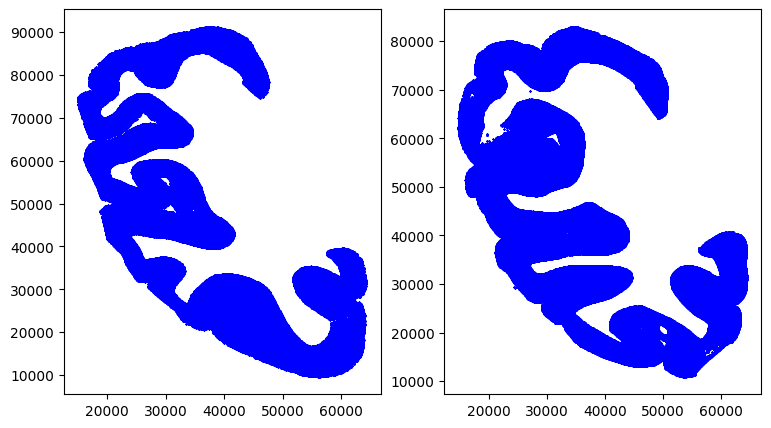

In [13]:
import matplotlib.pyplot as plt

s0_1 = [slice_0,slice_1]
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

for i, ax in enumerate(axs.flat):
    coo = pd.DataFrame(s0_1[i].obsm['spatial'])
    ax.scatter(coo[0], coo[1], c='b', marker='x',s=1)

plt.show()

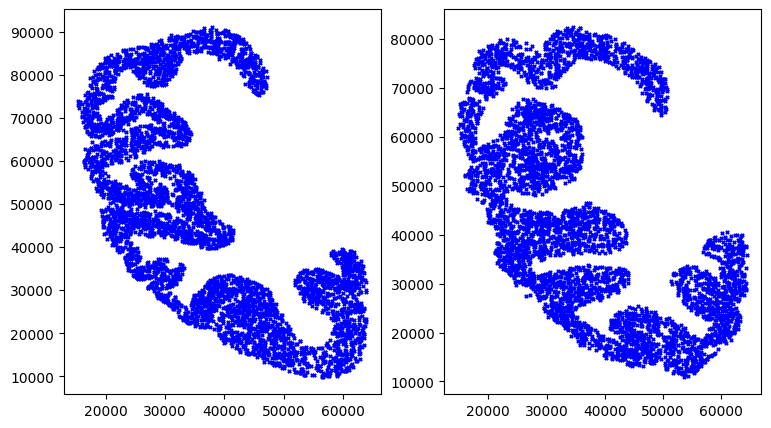

In [14]:
import matplotlib.pyplot as plt

s0_1 = [slice_0_subset_HVG,slice_1_subset_HVG]
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

for i, ax in enumerate(axs.flat):
    coo = pd.DataFrame(s0_1[i].obsm['spatial'])
    ax.scatter(coo[0], coo[1], c='b', marker='x',s=5)

plt.show()

In [15]:
'''
get_pi
get_edge_index
'''

# 指定使用第二个GPU
torch.cuda.set_device(1)  # 将设备设置为 'cuda:1'

s1_s2_pi = pairwise_align(sliceA=slice_0_subset_HVG,sliceB=slice_1_subset_HVG, backend = ot.backend.TorchBackend(), use_gpu = True, numItermax=5000)

# pairwise_align(slices[i], slices[i+1], backend = ot.backend.TorchBackend(), use_gpu = True,numItermax=2000)


gpu is available, using gpu.


/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [16]:
s1_s2_pi

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
from scipy.sparse import coo_matrix

def get_edge_index(M):
    # 将稠密矩阵M转换为稀疏矩阵，并获得边的索引edge_index 
    M_ = coo_matrix(M) # 稠密矩阵--->稀疏矩阵
    values = M_.data
    indices = np.vstack((M_.row, M_.col))  # 我们真正需要的coo形式
    adj = torch.LongTensor(indices)
    return adj

edge_index = get_edge_index(s1_s2_pi)
print(len(edge_index[0]))
print(edge_index)


# count = 0
# for i,arr in enumerate(s1_s2_pi):
#     for j,pi in enumerate(arr):
#         if pi !=0:
#             print(f'({i}, {j}):\t\t{pi}')
#             count+=1
            
# print('count: {count}')

5000
tensor([[   0,    1,    2,  ..., 4997, 4998, 4999],
        [4764, 2376, 3800,  ..., 1739,  544, 1650]])


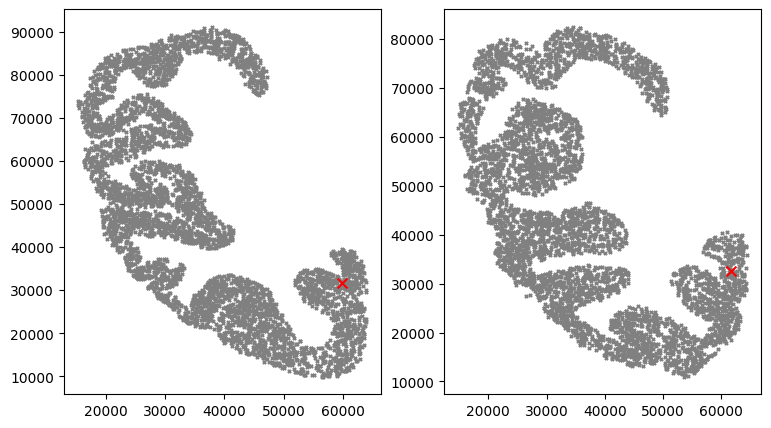

In [18]:
def plt_aligned_point(choiced_index):
    '''
    随机选取两个对齐的spot
    展示两个点的坐标
    持续1s
    '''
    coo_all_0 = slice_0_subset_HVG.obsm['spatial']
    coo_all_1 = slice_1_subset_HVG.obsm['spatial']

    aligned_point_0 = coo_all_0[edge_index[0,choiced_index]]
    aligned_point_1 = coo_all_1[edge_index[1,choiced_index]]

    fig, axs = plt.subplots(1, 2, figsize=(9, 5))
    # 背景
    axs[0].scatter(coo_all_0[:, 0], coo_all_0[:, 1], c='gray', marker='x',s=5)
    axs[1].scatter(coo_all_1[:, 0], coo_all_1[:, 1], c='gray', marker='x',s=5)
    # 对齐的两个点
    axs[0].scatter(aligned_point_0[0], aligned_point_0[1], c='r', marker='x',s=50)
    axs[1].scatter(aligned_point_1[0], aligned_point_1[1], c='r', marker='x',s=50)    

    plt.show()
    # display(plt.gcf())
    time.sleep(1)  # 等待1秒钟
    clear_output(wait=True)


import time
from IPython.display import clear_output, display

for i in range(15):
    choiced_index = np.random.randint(3000)
    plt_aligned_point(choiced_index)
